In [14]:
import gym
import numpy as np
from gym import spaces
import random as rand
from scipy.integrate import odeint
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env


import julia
jl = julia.Julia(sysimage="julia_img.so")
from julia import Main



In [2]:

class ABC_env_gym(gym.Env):
    """
    Environment is 3D ABC environment!! 
    """
    def __init__(self,A,B,C,start_sep, beta, kappa, D, nu,seed=1):
        """ 
        - proper value for D should be derived from sampled lyapunov exponent
        """
        Main.include("abc_numerics.jl")

        super().__init__()
        self.A = A
        self.B = B
        self.C = C
        self.rng = np.random.default_rng(seed=seed)
        self.start_sep = start_sep
        self.sep_vec = self.rng.random(3) - 0.5
        self.sep_vec = self.sep_vec*start_sep/np.linalg.norm(self.sep_vec)
        self.passive = (self.rng.random(3) - 0.5) * 2 * np.pi
        self.active = self.active = self.passive + self.sep_vec
        self.reward=0
        self.deltaT=0.1 # environment step size
        self.time_step=0
        self.limit=10.
        self.kappa = kappa
        self.D = D
        self.nu = nu
        self.beta = beta
        
        
        self.action_space = spaces.Box(low=np.array([-5.]), high=np.array([5.]),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-100,-100,-100]),
                                            high=np.array([100,100,100],
                                            dtype=np.float32))

    # need to track active and passive not just separation vector

    def reset(self):
        self.sep_vec = self.rng.random(3) - 0.5
        self.sep_vec = self.sep_vec*self.start_sep/np.linalg.norm(self.sep_vec)
        self.passive = (self.rng.random(3) - 0.5) * 2 * np.pi
        self.active = self.active = self.passive + self.sep_vec
        self.reward=0
        self.time_step=0
        return np.array(self.getState(),dtype=np.float32)

    def step(self,action):
        # actions are just a selection of phi for this
        phi = action
        state_string = np.array2string(np.append(self.passive,self.active), separator=",")
        self.passive,self.active, penalty = Main.eval(f"envStep({self.A},{self.B},{self.C},{float(phi)}, {self.nu}, {self.kappa}, {self.beta}, {state_string},{self.deltaT})") 
        self.sep_vec = self.passive - self.active
        self.time_step += 1
        reward = -penalty
        return np.array(self.getState(),dtype=np.float32), reward, self.isOver(), {}


    def eval_step(self,phi):
        """
        Returns the baseline aproximate for the given phi value and the current state

        NOTE: In training you should always evaluate for a fixed phi not the phi the agent picks. 

        """

        dims = 3
        d_tilde = (dims+2) * (dims-1) * self.D
        #useful intermediate value used in the baseline mutiple times
        block = self.nu + 2*phi - d_tilde
        time_remaining = self.limit - self.getTime()
        a = ((self.beta + phi**2)*(1-np.exp(-time_remaining*block)))/block
        b_term1 = dims * self.kappa * (self.beta + phi**2) / (self.nu*(2*phi-d_tilde))
        b_term2 = 1 - np.exp(-self.nu*time_remaining) - self.nu * (1-np.exp(-time_remaining*block))/block
        b = b_term1 * b_term2
        return -(a*self.dist()**2 + b)




    def getState(self):
        return self.sep_vec
    
    def isOver(self):
        return self.time_step * self.deltaT >= self.limit
        
    def dist(self):
        return np.linalg.norm(self.sep_vec)

    def getTime(self):
        return self.time_step * self.deltaT


In [3]:
# PARAMS
A = 1.
B = 0.7
C = 0.43
NU = 0.99
kappa = 0.001
BETA = 0.1
baseline_phi = 0.4
D = 0.1 # placeholder for now
dims = 3

In [4]:
env = ABC_env_gym(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
# It will check your custom environment and output additional warnings if needed
check_env(env)

/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/cfckoh/anaconda3/envs/stableBase3/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:361: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [15]:
num_eps = 500
steps = env.limit/env.deltaT * num_eps
model_A2C = A2C("MlpPolicy", env, verbose=1)
model_A2C.learn(total_timesteps=steps)
model.save("stablebase_A2C")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -687     |
| time/                 |          |
|    fps                | 480      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0.958    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.115   |
|    std                | 0.982    |
|    value_loss         | 0.00902  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -4e+08   |
| time/                 |          |
|    fps                | 505      |
|    iterations   

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -6.69e+08 |
| time/                 |           |
|    fps                | 522       |
|    iterations         | 1400      |
|    time_elapsed       | 13        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -1.18     |
|    explained_variance | 0.00438   |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | -59.1     |
|    std                | 0.787     |
|    value_loss         | 5.29e+03  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -6.24e+08 |
| time/                 |           |
|    fps                | 521       |
|    iterations         | 1500      |
|    time_elapsed       | 14        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -5.21e+09 |
| time/                 |           |
|    fps                | 524       |
|    iterations         | 2700      |
|    time_elapsed       | 25        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -0.995    |
|    explained_variance | -1.05     |
|    learning_rate      | 0.0007    |
|    n_updates          | 2699      |
|    policy_loss        | -9.48     |
|    std                | 0.653     |
|    value_loss         | 24.5      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -5.21e+09 |
| time/                 |           |
|    fps                | 523       |
|    iterations         | 2800      |
|    time_elapsed       | 26        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -1.03e+08 |
| time/                 |           |
|    fps                | 521       |
|    iterations         | 3900      |
|    time_elapsed       | 37        |
|    total_timesteps    | 19500     |
| train/                |           |
|    entropy_loss       | -0.833    |
|    explained_variance | -6.73     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3899      |
|    policy_loss        | 0.0283    |
|    std                | 0.557     |
|    value_loss         | 0.00372   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -1.03e+08 |
| time/                 |           |
|    fps                | 521       |
|    iterations         | 4000      |
|    time_elapsed       | 38        |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -2.96e+07 |
| time/                 |           |
|    fps                | 516       |
|    iterations         | 5200      |
|    time_elapsed       | 50        |
|    total_timesteps    | 26000     |
| train/                |           |
|    entropy_loss       | -0.752    |
|    explained_variance | -18.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 5199      |
|    policy_loss        | 0.42      |
|    std                | 0.513     |
|    value_loss         | 0.161     |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -2.96e+07 |
| time/                 |           |
|    fps                | 516       |
|    iterations         | 5300      |
|    time_elapsed       | 51        |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -7.2e+05 |
| time/                 |          |
|    fps                | 514      |
|    iterations         | 6500     |
|    time_elapsed       | 63       |
|    total_timesteps    | 32500    |
| train/                |          |
|    entropy_loss       | -0.698   |
|    explained_variance | -15.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 6499     |
|    policy_loss        | -0.00367 |
|    std                | 0.486    |
|    value_loss         | 6.32e-05 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -7.2e+05  |
| time/                 |           |
|    fps                | 514       |
|    iterations         | 6600      |
|    time_elapsed       | 64        |
|    total_timesteps    | 3300

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -5.37e+05 |
| time/                 |           |
|    fps                | 517       |
|    iterations         | 7800      |
|    time_elapsed       | 75        |
|    total_timesteps    | 39000     |
| train/                |           |
|    entropy_loss       | -0.612    |
|    explained_variance | -325      |
|    learning_rate      | 0.0007    |
|    n_updates          | 7799      |
|    policy_loss        | -0.00245  |
|    std                | 0.446     |
|    value_loss         | 5.36e-05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 100       |
|    ep_rew_mean        | -5.37e+05 |
| time/                 |           |
|    fps                | 517       |
|    iterations         | 7900      |
|    time_elapsed       | 76        |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -6.28    |
| time/                 |          |
|    fps                | 511      |
|    iterations         | 9100     |
|    time_elapsed       | 88       |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | -0.609   |
|    explained_variance | -5.15    |
|    learning_rate      | 0.0007   |
|    n_updates          | 9099     |
|    policy_loss        | -0.0228  |
|    std                | 0.445    |
|    value_loss         | 0.00185  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 100      |
|    ep_rew_mean        | -8.31    |
| time/                 |          |
|    fps                | 510      |
|    iterations         | 9200     |
|    time_elapsed       | 90       |
|    total_timesteps    | 46000    |
|

In [21]:
model_PPO = PPO("MlpPolicy", env, verbose=1)
model_PPO.learn(total_timesteps=steps)
model_PPO.save("stablebase_PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -326     |
| time/              |          |
|    fps             | 691      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -503        |
| time/                   |             |
|    fps                  | 574         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004290186 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -256         |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 11           |
|    time_elapsed         | 42           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0025813268 |
|    clip_fraction        | 0.0085       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | -0.243       |
|    learning_rate        | 0.0003       |
|    loss                 | 234          |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00199     |
|    std                  | 0.965        |
|    value_loss           | 1.54e+03     |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -6.88       |
| time/                   |             |
|    fps                  | 519         |
|    iterations           | 20          |
|    time_elapsed         | 78          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008971587 |
|    clip_fraction        | 0.0405      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.423       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.56        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00291    |
|    std                  | 0.917       |
|    value_loss           | 18.7        |
-----------------------------------------
------------------------------------------
| rollout/                |      

### Now compare to other agents

In [5]:
import matplotlib.pyplot as plt
from abc_env import ABC_env
from naive_agents import DoNothing, FixedPhi
#from dynamic_phi_agent import DynamicPhiAgent
from actor_physicists_abc import RL_phi_agent

In [18]:
model_A2C = A2C("MlpPolicy", env, verbose=1)
model_PPO = PPO("MlpPolicy", env, verbose=1)
model_A2C.load("stablebase_A2C.zip")
model_PPO.load("stablebase_PPO.zip")

num_eps = 1000
state = env.reset()
results = {}
env.deltaT=0.1
for stable_model,name in [(model_A2C,"A2C"),(model_PPO,"PPO")]:
    cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
    for ep in range(num_eps):
        step=0
        episode_rew=0
        while not env.isOver():
            action,_ = stable_model.predict(state)
            state, reward, _, _ = env.step(action)
            episode_rew += reward
            step+=1
            cum_rew[step] = episode_rew
        state = env.reset()
    results[name]=cum_rew
    

    

phi=1.1
agent = RL_phi_agent(dims,action_scale=5.)
agent.load_policy(f"saved_models/abc_env_{phi}_10.0.pt")
env2 = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)

cum_rew=np.zeros(int(env2.limit/env2.deltaT)+1)
for ep in range(num_eps):
    step=0
    episode_rew=0
    while not env2.isOver():
        action = agent.sample_action(env2.getState())
        reward = env2.step(action)
        episode_rew += reward
        step+=1
        cum_rew[step] = episode_rew
    state = env2.reset()
results["Actor Physicist"] = cum_rew

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


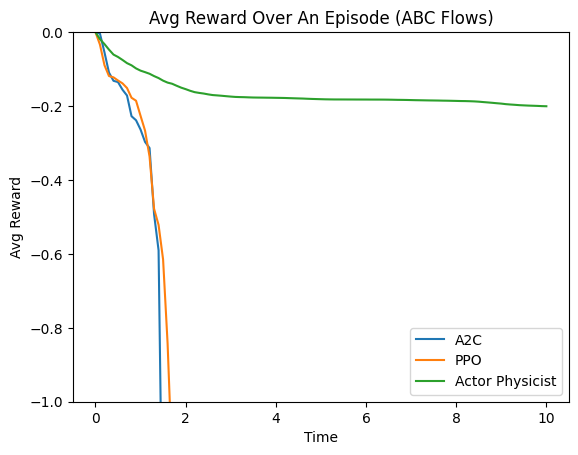

In [23]:
labels = []
for name,rews in results.items():
    labels.append(name)
    plt.plot(np.arange(len(rews))/10,rews)
plt.legend(labels=labels)
plt.title("Avg Reward Over An Episode (ABC Flows)")
plt.xlabel("Time")
plt.ylabel("Avg Reward")
plt.ylim(-1,0.)
plt.savefig(f"figs/compare_out_of_box.pdf", format="pdf", bbox_inches="tight")

In [83]:
actions=[]
state = env.reset()
final_eps_rewards = []
for ep in range(num_eps):
    step=0
    episode_rew=0
    while not env.isOver():
        action,_ = model.predict(state)
        actions.append(float(action))
        state, reward, _, _ = env.step(action)
        episode_rew += reward
        step+=1
        cum_rew[step] = episode_rew
    final_eps_rewards.append(episode_rew)
    state = env.reset()

(-1.6, 0.0)

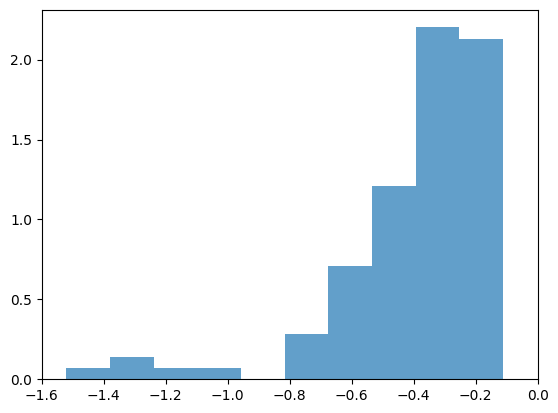

In [84]:
_= plt.hist(final_eps_rewards,bins=1000,density=True,alpha=0.7)
plt.xlim(-1.6,0)

In [85]:
sum(final_eps_rewards)/num_eps

-1.8401280816460521

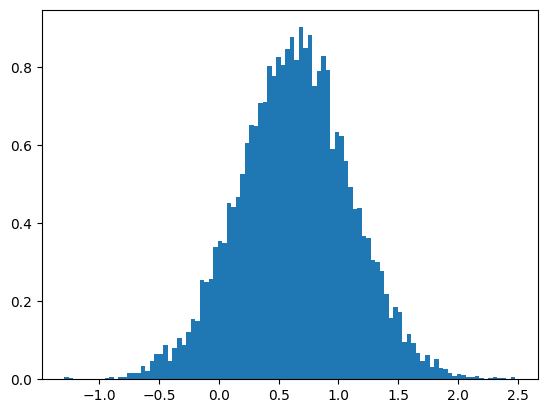

In [75]:
_= plt.hist(actions,bins=100,density=True)

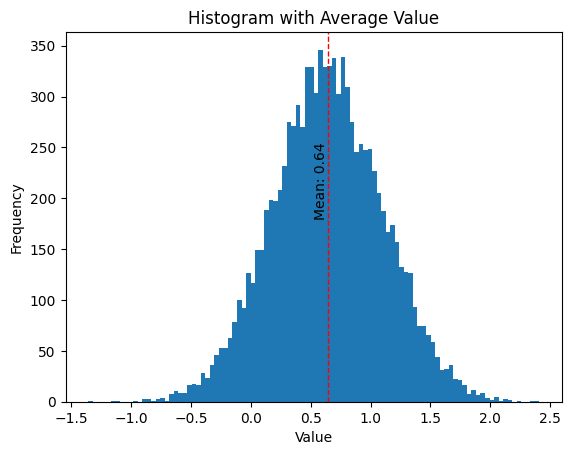

In [98]:
# Plot histogram
plt.hist(actions, bins=100)

# Calculate average value
average_value = np.mean(actions)

# Plot vertical line at the average value
plt.axvline(average_value, color='red', linestyle='dashed', linewidth=1)

# Add label for the average value
plt.text(average_value, plt.ylim()[1]*0.5, f'Mean: {average_value:.2f}', color='black', fontsize=10, ha='right', rotation=90)

# Add title and labels
plt.title('Histogram with Average Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [24]:
#TODO
# run num_eps
# plot evolution of avg reward over an episode of out of box methods vs fixed vs our RL

In [ ]:
episode_rew=0
    while not env.isOver():
        action=agent.sample_action(state)
        state, reward, _, _ = env.step(action)
        
    print(f"final distance: {env.dist()}")
    state = env.reset()
